In [38]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
from scipy.optimize import curve_fit
import operator
#import scipy as scp


# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data

oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            #continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column',col_numb,'values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        #print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals


# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)
def dict_2D_plot(input_dict,ax,col_x,col_y,var_names,col_map):
    label_int = 60
    if (col_x == 1):
        label_int = 1
    elif (col_x == 2):
        label_int = 0
        
    plt.gca().set_color_cycle([col_map(j) for j in np.linspace(1, 0, len(input_dict))])
    # grid_vals_dict gives the fixed value as the key for the array
    for i in reversed(sorted(input_dict.iterkeys())):
        ax.plot((input_dict[i])[:,(col_x-1)],(input_dict[i])[:,(col_y-1)],label=(var_names[label_int] + '=' + i))
    ax.set_xlabel(var_names[(col_x-1)])
    ax.set_ylabel(var_names[(col_y-1)])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.1))
    #ax.set_title('Stuff',y=1.05)
    plt.show()
    
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        #print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict

# check Casagrande dictionary - is it just the same as before? Shouldn't be!
def casa_check(A_X_dict,casa_A_X_dict,casa_Teff):
    diff_dict = {}
    offset_arr = []
    temp_arr = []
    combined_set = set(A_X_dict).intersection(set(casa_A_X_dict))
    print 'combined set size:',len(combined_set)
    for key_val in combined_set:
        A_arr_kv = A_X_dict[key_val]
        casa_arr_kv = casa_A_X_dict[key_val]
        for m in range(len(A_arr_kv[:,0])):
            for n in range(len(casa_arr_kv[:,0])):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                if ((casa_arr_kv[n,0] == A_arr_kv[m,0] and casa_arr_kv[n,1] == A_arr_kv[m,1])):
                    offset_arr.append(casa_arr_kv[n,0])
                    offset_arr.append(casa_arr_kv[n,1])
                    for j in range(2,5):
                        offset_arr.append(casa_arr_kv[n,j] - A_arr_kv[m,j])
                    temp_arr.append(offset_arr)
        diff_dict[key_val] = np.array(temp_arr)
    return diff_dict
                            
                
# general fits write-out function

def general_fit_number_gen_write(f,func_type,func_coeffs,covar_matrix,filter_str,logg_val,avg_dict):
    frac_list = []
    output_names = ['    Fit coefficients (in order of functions'' arguments):','    Covariance matrix:']
    f.write('Fitting results for ' + str(filter_str) + ' filter, with log(g) = ' + str(logg_val) + '\n')
    f.write('Function type:  ' + func_type + '\n')
    f.write(output_names[0] + '\n')
    f.write(str(func_coeffs) + '\n')
    f.write(output_names[1] + '\n')
    f.write(str(covar_matrix) + '\n')
    f.write('Fractional errors in fit coefficients = {E[(X(i)-E[X(i)])*(X(j)-E[X(j)])]}/{|E[X(i)]*E[X(j)]|}' + '\n')
    f.write('i.e., covariance(i,j)/{coef(i)*coef(j)}' + 2*'\n')
    f.write('Fractional error output:  ' + '\n')
    # write out errors as detailed above
    
    sum_y = 0
    yterm_count = 0
    for i in range(len(func_coeffs)):
        f.write('row ' + str(i+1) + 2*'\t')
        for j in range(len(func_coeffs)):
            # use if statement to avoid repeating terms in symmetrical covariance matrix
            # should result in increasing number of entries for increasing row number
            if (j <= i):
                y = abs(covar_matrix[i][j]/(func_coeffs[i]*func_coeffs[j]))
                f.write(str(y) + '\t')
                yterm_count += 1
                sum_y += y
        f.write('\n')
    f.write('\n')
    avg_y = sum_y/yterm_count
    avg_dict[func_type] = avg_y
    f.write('Average fractional error = ' + str(avg_y) + 2*'\n')
    print 'Average fractional error for ' + func_type + ' = ' + str(avg_y)
    
# Modelling functions below!!!

# single power-law term
def single_poly(xdata,a,b,c):
    y = a*(xdata**b) + c
    return y

# exponential function
def exp_func(xdata,a,b,c):
    y = (a*(np.exp(b*xdata))) + c
    return y


# logarithmic function
def log_func(xdata,a,b,c):
    y = (a*(np.log10(b*xdata))) + c
    return y

# exponential function added to Teff^d
def single_poly_plus_exp_func(xdata,a,b,c,d):
    y = (xdata**d) + (a*(np.exp(b*xdata))) + c
    return y


# functions to reproduce Casagrande & Vandenberg (in prep.) behaviour
def casa_T4_range(Teff_vals,min_val,max_val):
    T4_list = []
    Teff_list = []
    #if (min_val in Teff_vals and max_val in Teff_vals):
    for i in Teff_vals:
        if (min_val <= i <= max_val):
            Teff_list.append(i)
            # T4 defined as Teff*(10^-4)
            T4_list.append(i*(1.0e-4))
    #else:
    T4r = np.array(T4_list)
    Teffr = np.array(Teff_list)
    return Teffr,T4r

def casa_ext_coeff_profile(a,b,c,d,T4,FeH):
    # extinction coefficient, R_X = A(X)/E(B-V) ALWAYS!!!
    # -> need to find E(B-V) values, then use to compare
    R_X = a + T4*(b + c*T4) + d*FeH
    return R_X

# try a function to reduce oppportunities for error for stuff below
# during curve fitting - tests, plots & writes out figure, writes out results of covariance matrix analysis

def filter_curve_plot_write(key,metal,exp_bounds,pow_bounds,spp_bounds,filter_str,folder,graph_fold,casa_opt):
    if (metal == 'solar'):
        A_X_chosen = A_X_zs_gfix[key]
        casa_chosen = casa_A_X_zs_gfix[key]
    elif (metal == 'sol_100'):
        A_X_chosen = A_X_z2_gfix[key]
        casa_chosen = casa_A_X_z2_gfix[key]
    else:
        print 'Error! Incorrect metallicity input'
        A_X_chosen = []
    # Iteration for changes BETWEEN filters !!!
    # i.e., should produce 3 versions of each output each time the function is called
    for i in range(2,len(A_X_chosen[0,:])):
        # empty directory string - avoid potential concatonation
        plot_dir_str_i = None
        data_dir_str_i = None
        # curve-fitting commands
        exp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=exp_bounds[i-2])
        pow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=pow_bounds[i-2])
        spp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,A_X_chosen[:,0],A_X_chosen[:,i], p0=None, sigma=None,bounds=spp_bounds[i-2])
        
        # print fitting results
        print 'Exponential fit coefficients: '
        print exp_fit_A_G5zs
        print 'Covariance matrix: '
        print covarr_A_G5zs_ef

        print 'Teff^(n) fit coefficients: '
        print pow_fit_A_G5zs
        print 'Covariance matrix: '
        print covarr_A_G5zs_pow

        print 'Teff^(n) + exponential fit coefficients: '
        print spp_exp_fit_A_G5zs
        print 'Covariance matrix: '
        print covarr_A_G5zs_spp
        
        # Construct directories, files to save plots,data - i.e. construct strings
        # String format should be: 'gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf' (example case)
        if (casa_opt == 'y' and i==2):
            folder += '_casa'
            graph_fold += '_casa'
            
        plot_dir_str_i = folder + '/' + graph_fold + '/A' + filter_str[i-2] + '_logg=' + key + '_' + metal + '_Teff_fit_plot'
        data_dir_str_i = folder + '/Teff_A' + filter_str[i-2] + '_gen_fit_logg=' + key + '_' + metal + '_numbers'
        # separate Casgrande data
        if (casa_opt == 'y' and i==2):
            plot_dir_str_i += '_casa'
            data_dir_str_i += '_casa'
        plot_dir_str_i += '.pdf'
        data_dir_str_i += '.txt'
        
        # plot commands
        fig, ax = plt.subplots()
        ax.set_xlabel(var_names[0])
        ax.set_ylabel(var_names[i])
        # - 0.01 (data - 0.01) *max(A_X_chosen[:,i])
        # + 0.01 (data + 0.01) *max(A_X_chosen[:,i])
        ax.plot(A_X_chosen[:,0],A_X_chosen[:,i],'k',label='Data')
        ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01*max(data))')
        ax.plot(A_X_chosen[:,0],(A_X_chosen[:,i] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01*max(data))')
        ax.plot(A_X_chosen[:,0],exp_func(A_X_chosen[:,0],*exp_fit_A_G5zs),'m',label=fit_types[0])
        ax.plot(A_X_chosen[:,0],single_poly(A_X_chosen[:,0],*pow_fit_A_G5zs),'g',label=fit_types[1])
        ax.plot(A_X_chosen[:,0],single_poly_plus_exp_func(A_X_chosen[:,0],*spp_exp_fit_A_G5zs),'r',label=fit_types[2])
        if (casa_opt == 'y'):
            ax.plot(casa_chosen[:,0],casa_chosen[:,i],'b',label='Casagrande data')
            
        #ax.set_xlim(3000,10000)
        plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
        plt.show()
        fig.savefig(plot_dir_str_i, bbox_inches='tight')
                
        # data file write commands
        
        avg_dict = {}
        with open (data_dir_str_i,'w') as f:
            print '\n    Writing log(g)=' + key + ', Z = ' + metal + ' model'
            general_fit_number_gen_write(f,fit_types[0],exp_fit_A_G5zs, covarr_A_G5zs_ef,filter_str[i-2],float(key),avg_dict)
            general_fit_number_gen_write(f,fit_types[1],pow_fit_A_G5zs, covarr_A_G5zs_pow,filter_str[i-2],float(key),avg_dict)
            general_fit_number_gen_write(f,fit_types[2],spp_exp_fit_A_G5zs, covarr_A_G5zs_spp,filter_str[i-2],float(key),avg_dict)

            # write results of comparison of averages
            sorted_avg = sorted(avg_dict.items(), key=operator.itemgetter(1))
            f.write('RANKED MEAN FRACTIONAL ERRORS (best to worst) :   ' + '\n')
            for j in sorted_avg:
                f.write("{: <40}".format(str(j[0])) + 2*'\t' + str(j[1]) + '\n')
            f.close()
            
        with open (folder + '/coeffs_summary_cas.txt','a') as sf:
            #sf.write('Fit coefficients summary
            sf.write('log(g) = ' + key + ', Z = ' + metal + ', ' + filter_str[i-2] + ' filter ' + 3*'\t' + str(pow_fit_A_G5zs) + '\n')
        sf.close()
        print 'Writing complete for ' + filter_str[i-2] + ' filter'
    print '\n Writing complete for log(g) = ' + key + ', Z = ' + metal + ' configuration, END OF FUNCTION WRITING!!!'

# END OF FUNCTION DEFINITION

print 'modules loaded & functions compiled'

modules loaded & functions compiled


In [40]:
# N.B.: using cgs unit
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)
      
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)

# Casagrande files   
with open ("gaia_spectra/casa_output_A0_zsolar") as casAv0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av0zs_data = data_read_gaia(casAv0zs)
    
with open ("gaia_spectra/casa_output_A1_zsolar") as casAv1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model'
    casa_Av1zs_data = data_read_gaia(casAv1zs)
    
with open ("gaia_spectra/casa_output_A0_z10-2") as casAv0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av0z2_data = data_read_gaia(casAv0z2)
    
with open ("gaia_spectra/casa_output_A1_z10-2") as casAv1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model'
    casa_Av1z2_data = data_read_gaia(casAv1z2)

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'

# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
# Casagrande dictionaries
casa_Av0zs_logg_fix,casa_Av0zs_logg_vals = grid_vals_dict(casa_Av0zs_data,2)
casa_Av1zs_logg_fix,casa_Av1zs_logg_vals = grid_vals_dict(casa_Av1zs_data,2)
casa_Av0z2_logg_fix,casa_Av0z2_logg_vals = grid_vals_dict(casa_Av0z2_data,2)
casa_Av1z2_logg_fix,casa_Av1z2_logg_vals = grid_vals_dict(casa_Av1z2_data,2)
#print Av0z2_logg_fix['5.0']

"""
print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)
"""

print '****Finished arrays****'
#print type(Av0zs_Teff_vals[0])
A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

casa_A_X_zs_gfix = diff_grid_dict(casa_Av0zs_logg_fix,casa_Av1zs_logg_fix)
casa_A_X_z2_gfix = diff_grid_dict(casa_Av0z2_logg_fix,casa_Av1z2_logg_fix)

Teff_5_zs = (A_X_zs_gfix['5.0'])[:,0]
# convert Teff to logs
log_Teff_5_zs = np.log10(Teff_5_zs)
A_G_5_zs = (A_X_zs_gfix['5.0'])[:,2]
A_Gbp_5_zs = (A_X_zs_gfix['5.0'])[:,3]
A_Grp_5_zs = (A_X_zs_gfix['5.0'])[:,4]

Teff_5_z2 = (A_X_z2_gfix['5.0'])[:,0]
# convert Teff to logs
log_Teff_5_z2 = np.log10(Teff_5_z2)
A_G_5_z2 = (A_X_z2_gfix['5.0'])[:,2]
A_Gbp_5_z2 = (A_X_z2_gfix['5.0'])[:,3]
A_Grp_5_z2 = (A_X_z2_gfix['5.0'])[:,4]

# casagrande Teff ranges
casa_Teff,casa_T4 = casa_T4_range(Teff_5_zs,5250,7000)
print casa_T4

casa_zs_check = casa_check(A_X_zs_gfix,casa_A_X_zs_gfix,casa_Teff)
casa_z2_check = casa_check(A_X_z2_gfix,casa_A_X_z2_gfix,casa_Teff)

print 'checker', len(casa_zs_check)
print casa_zs_check['5.0']

#print type(A_X_z2_gfix)
#print type(A_X_z2_gfix['0.0'])

#print A_X_z2_gfix['5.0'][0:4,2:5]
#print casa_A_X_z2_gfix['5.0'][0:4,2:5]

casa_count = 0
for key in casa_A_X_z2_gfix:
    #print casa_A_X_z2_gfix[key]
    for data in np.nditer(casa_A_X_z2_gfix[key]):
        if (data != 0.0):
            casa_count += 1
    print casa_count
#A_X_zs_Tfix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
#A_X_z2_Tfix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)


var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$','log($T_{eff}$ / K)']

# sort data into columns

# strings describing functions being fitted to the data
fit_types = []

fit_types.append('Exponential function of Teff, fitted')
fit_types.append('Power law of Teff, fitted')
fit_types.append('Power law + exponential function of Teff, fitted')

#print len(fit_types)
print 'Variable data arrays organized'
#print min(Teff_5_z2),max(Teff_5_z2)
#print A_X_z2_gfix['0.0'].shape
#print (A_X_z2_gfix['0.0'])[0,:]
#print (A_X_z2_gfix['0.0'])[0,:].shape



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = Zsolar Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) Casagrande & Vandenberg model
Total dataset:  (84L, 5L)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:

Exponential fit coefficients: 
[ -8.07640222e-01  -2.95857128e-04   1.00281426e+00]
Covariance matrix: 
[[  4.52675707e-04   1.25909424e-07   1.73296450e-05]
 [  1.25909424e-07   4.01107340e-11   7.19656317e-09]
 [  1.73296450e-05   7.19656317e-09   2.30131124e-06]]
Teff^(n) fit coefficients: 
[ -1.00000000e+04  -1.26033075e+00   1.04498039e+00]
Covariance matrix: 
[[  1.85937552e+07   2.30492171e+02   2.11250167e+01]
 [  2.30492171e+02   2.86000443e-03   2.64723419e-04]
 [  2.11250167e+01   2.64723419e-04   2.80113092e-05]]
Teff^(n) + exponential fit coefficients: 
[ -8.07639689e-01  -2.95856975e-04   1.00281428e+00  -4.12188099e+00]
Covariance matrix: 
[[  4.62105506e-04   1.28532352e-07   1.76906668e-05   0.00000000e+00]
 [  1.28532352e-07   4.09463453e-11   7.34649259e-09   0.00000000e+00]
 [  1.76906668e-05   7.34649259e-09   2.34925690e-06   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]]


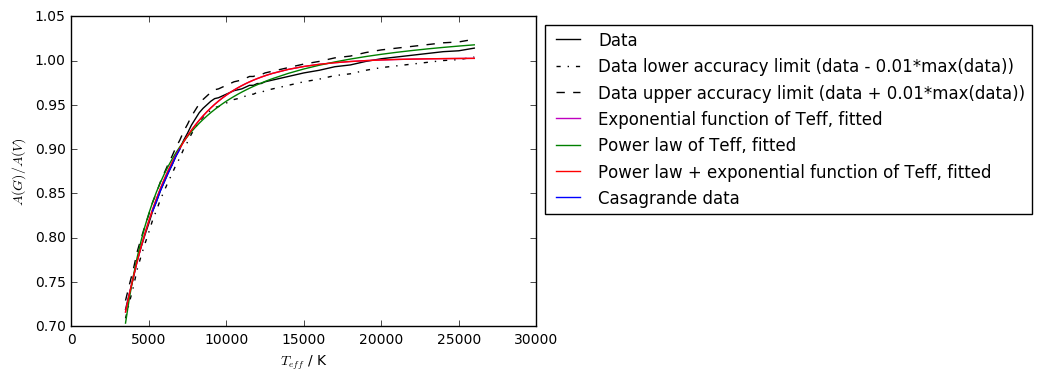


    Writing log(g)=3.0, Z = sol_100 model
Average fractional error for Exponential function of Teff, fitted = 0.000287851448191
Average fractional error for Power law of Teff, fitted = 0.0347124206656
Average fractional error for Power law + exponential function of Teff, fitted = 0.000176308963584
Writing complete for G filter
Exponential fit coefficients: 
[ -4.45791083e-01  -2.27802811e-04   1.18626791e+00]
Covariance matrix: 
[[  3.22156576e-04   1.58341366e-07   2.31355175e-05]
 [  1.58341366e-07   9.71471008e-11   1.98243525e-08]
 [  2.31355175e-05   1.98243525e-08   6.34715548e-06]]
Teff^(n) fit coefficients: 
[-9.99999994 -0.39998747  1.38180331]
Covariance matrix: 
[[  3.15711980e+01   4.79203705e-01   3.09153594e-01]
 [  4.79203705e-01   7.28751935e-03   4.72526234e-03]
 [  3.09153594e-01   4.72526234e-03   3.10625795e-03]]
Teff^(n) + exponential fit coefficients: 
[ -4.45786794e-01  -2.27800180e-04   1.18626845e+00  -2.97097221e+00]
Covariance matrix: 
[[  3.28855293e-04   1

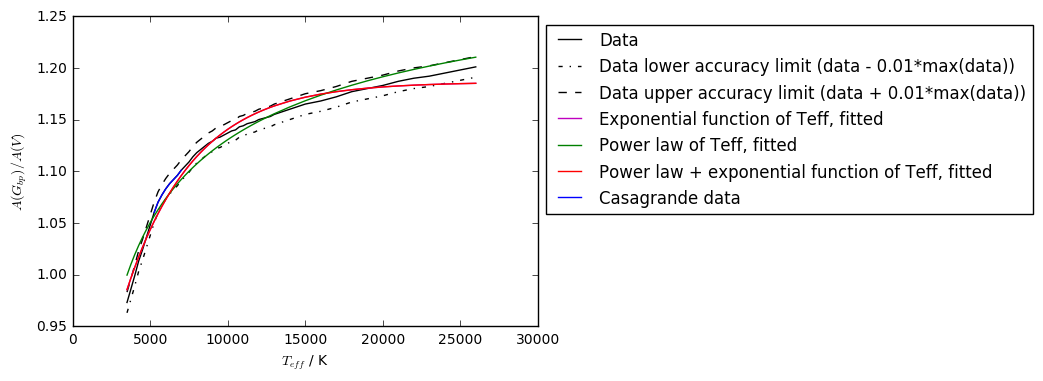


    Writing log(g)=3.0, Z = sol_100 model
Average fractional error for Exponential function of Teff, fitted = 0.000862321783082
Average fractional error for Power law of Teff, fitted = 0.0856026514788
Average fractional error for Power law + exponential function of Teff, fitted = 0.000528168619362
Writing complete for Gbp filter
Exponential fit coefficients: 
[ -1.45195136e-01  -2.82055996e-04   6.69364063e-01]
Covariance matrix: 
[[  2.73434895e-05   4.20911230e-08   1.18271017e-06]
 [  4.20911230e-08   7.51431379e-11   2.78373951e-09]
 [  1.18271017e-06   2.78373951e-09   1.79330699e-07]]
Teff^(n) fit coefficients: 
[-100.          -0.89081282   0.68598631]
Covariance matrix: 
[[  2.00555897e+03   2.56168886e+00   8.91169363e-02]
 [  2.56168886e+00   3.27594105e-03   1.14918011e-04]
 [  8.91169363e-02   1.14918011e-04   4.31456676e-06]]
Teff^(n) + exponential fit coefficients: 
[ -1.45193920e-01  -2.82053639e-04   6.69364171e-01  -4.86962956e+00]
Covariance matrix: 
[[  2.79122352e-

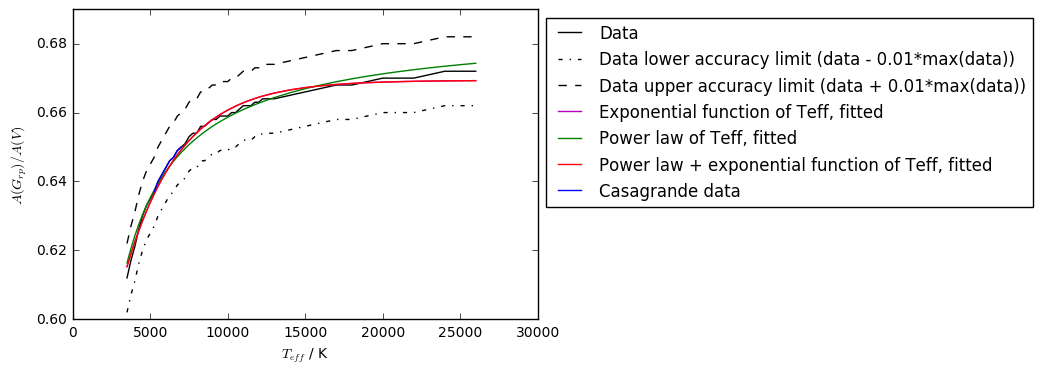


    Writing log(g)=3.0, Z = sol_100 model
Average fractional error for Exponential function of Teff, fitted = 0.00054944443871
Average fractional error for Power law of Teff, fitted = 0.0391562014517
Average fractional error for Power law + exponential function of Teff, fitted = 0.000336531887516
Writing complete for Grp filter

 Writing complete for log(g) = 3.0, Z = sol_100 configuration, END OF FUNCTION WRITING!!!


In [30]:
# GAIA FILTER PLOTTING
# filter string names
gaia_filter_str = ['G','Gbp','Grp']
# curve fitting coefficients' bounds
exp_bounds_G = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_G = ([-1.0e+04, -5., -1.], [1., 5., 5.])
spp_bounds_G = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds_Gbp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Gbp = ([-1.0e+01, -1., -5.], [1., 1., 5.])
spp_bounds_Gbp = ([-1.0e+05, -10., -4., -5.], [1., 10., 3., 2.])

exp_bounds_Grp = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_Grp = ([-1.0e+02, -2., -5.], [1., 2., 5.])
spp_bounds_Grp = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds = [exp_bounds_G,exp_bounds_Gbp,exp_bounds_Grp]
pow_bounds = [pow_bounds_G,pow_bounds_Gbp,pow_bounds_Grp]
spp_bounds = [spp_bounds_G,spp_bounds_Gbp,spp_bounds_Grp]

#print exp_bounds
#print pow_bounds
#print spp_bounds


# call function to general results
#print float('5.0')
filter_curve_plot_write('3.0','sol_100',exp_bounds,pow_bounds,spp_bounds,gaia_filter_str,'gaia_spectra','gaia_graphs','y')


In [5]:
# Hubble data read
# N.B.: using cgs unit
with open ("HubWFC/H_OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)

with open ("HubWFC/H_OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)

with open ("HubWFC/H_OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = (10^(-2) Zsolar) model'
    Av0z2_data = data_read_gaia(Av0z2)

with open ("HubWFC/H_OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 1, Z = (10^(-2) Zsolar) model'
    Av1z2_data = data_read_gaia(Av1z2)

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)

"""
print '****Separating data into arrays by Teff values****'
Av0zs_Teff_fix,Av0zs_Teff_vals = grid_vals_dict(Av0zs_data,1)
Av1zs_Teff_fix,Av1zs_Teff_vals = grid_vals_dict(Av1zs_data,1)
Av0z2_Teff_fix,Av0z2_Teff_vals = grid_vals_dict(Av0z2_data,1)
Av1z2_Teff_fix,Av1z2_Teff_vals = grid_vals_dict(Av1z2_data,1)
"""

print '****Finished arrays****'

A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)

print type(A_X_z2_gfix)
print type(A_X_z2_gfix['0.0'])
#A_X_zs_Tfix = diff_grid_dict(Av0zs_Teff_fix,Av1zs_Teff_fix)
#A_X_z2_Tfix = diff_grid_dict(Av0z2_Teff_fix,Av1z2_Teff_fix)


var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(f218w)/A(V)$','$A(f225w)/A(V)$','$A(f275w)/A(V)$','$A(f300x)/A(V)$','$A(f336w)/A(V)$','$A(f390w)/A(V)$','$A(f438w)/A(V)$','$A(f475w)/A(V)$','$A(f555w)/A(V)$','$A(f606w)/A(V)$','$A(f625w)/A(V)$','$A(f775w)/A(V)$','$A(f814w)/A(V)$']

# 'log($T_{eff}$ / K)'

# Note: Teff is column 1, log(g) is column 2
print '****Creating arrays****'
print '****Separating data into arrays by log(g) values****'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
#print Av0z2_logg_fix['5.0']
#print A_X_z2_gfix['0.0'].shape
#print (A_X_z2_gfix['0.0'])[0,:].shape



    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 15L)

    Reading A(v) = 0, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)

    Reading A(v) = 1, Z = (10^(-2) Zsolar) model
Total dataset:  (476L, 15L)
****Creating arrays****
****Separating data into arrays by log(g) values****
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
Final dictionary length:  11
****Finished arrays****
11
Raw A(X) dictionary complete
11
Raw A(X) dictionary complete
<type 'dict'>
<type 'numpy.ndarray'>
****Creating arrays****
****Separating data into a

2.042
Exponential fit coefficients: 
[ -1.81037901e+01  -5.93940996e-04   2.95434556e+00]
Covariance matrix: 
[[  8.61207230e+00   1.12834744e-04   1.99755617e-02]
 [  1.12834744e-04   1.53973119e-09   3.28322826e-07]
 [  1.99755617e-02   3.28322826e-07   3.45067362e-04]]
Teff^(n) fit coefficients: 
[ -1.00000000e+07  -1.88719300e+00   3.06870717e+00]
Covariance matrix: 
[[  2.55830159e+14   3.08229107e+06   4.70498203e+05]
 [  3.08229107e+06   3.71729410e-02   5.77529282e-03]
 [  4.70498203e+05   5.77529282e-03   1.66495033e-03]]
Teff^(n) + exponential fit coefficients: 
[ -1.69422243e+01  -5.66734958e-04   2.60447986e+00  -1.04923454e-01]
Covariance matrix: 
[[  7.41693287e+00   9.74224081e-05  -7.18583551e+00   2.06022844e+00]
 [  9.74224081e-05   1.35366990e-09  -6.75843024e-05   1.94168019e-05]
 [ -7.18583551e+00  -6.75843024e-05   4.20529126e+01  -1.20282616e+01]
 [  2.06022844e+00   1.94168019e-05  -1.20282616e+01   3.44043355e+00]]


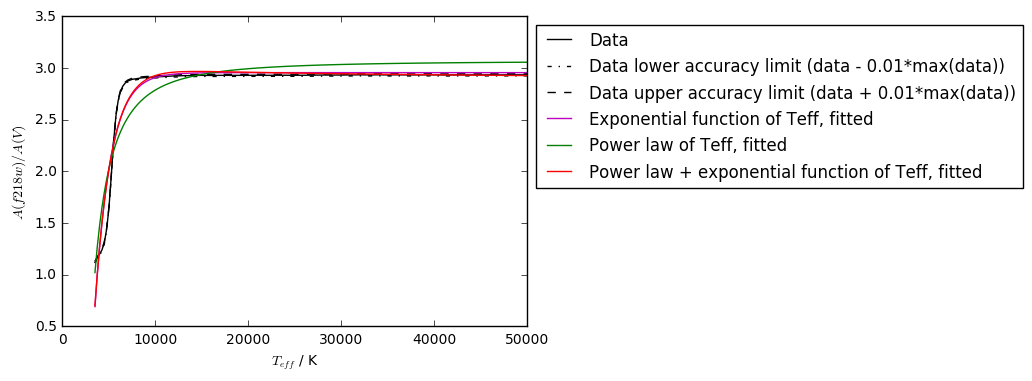


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00695586118546
Average fractional error for Power law of Teff, fitted = 0.458095328111
Average fractional error for Power law + exponential function of Teff, fitted = 36.4462621985
Writing complete for f218w filter
Exponential fit coefficients: 
[ -2.58097541e+01  -7.05041289e-04   2.62483996e+00]
Covariance matrix: 
[[  6.97688604e+00   6.60776017e-05   8.20838767e-03]
 [  6.60776017e-05   6.45068344e-10   9.41535797e-08]
 [  8.20838767e-03   9.41535797e-08   8.00353808e-05]]
Teff^(n) fit coefficients: 
[ -1.00000000e+04  -1.07719926e+00   2.88837957e+00]
Covariance matrix: 
[[  3.56523852e+08   4.35603168e+03   1.63936278e+03]
 [  4.35603168e+03   5.33099870e-02   2.03798274e-02]
 [  1.63936278e+03   2.03798274e-02   9.66790006e-03]]
Teff^(n) + exponential fit coefficients: 
[ -2.53996674e+01  -6.99068617e-04   2.61460165e+00  -4.62393957e-01]
Covariance matrix: 
[[  9.52316

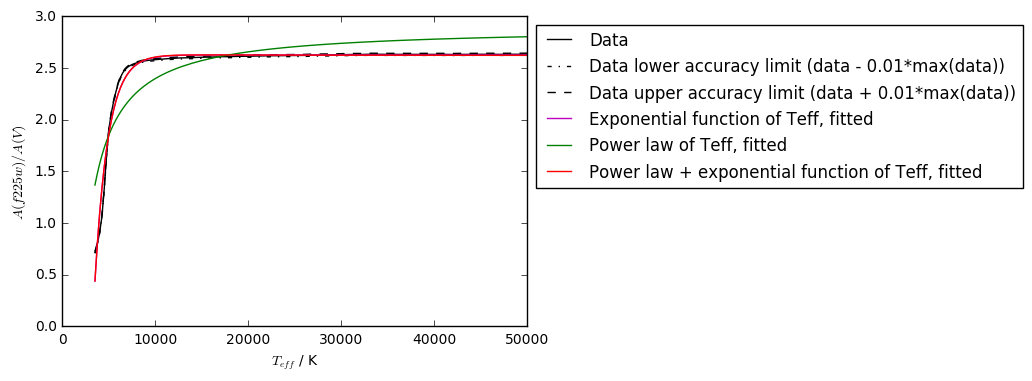


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00259769345093
Average fractional error for Power law of Teff, fitted = 0.680005386729
Average fractional error for Power law + exponential function of Teff, fitted = 0.109541953967
Writing complete for f225w filter
Exponential fit coefficients: 
[ -6.65645300e+00  -7.16394636e-04   2.05019946e+00]
Covariance matrix: 
[[  6.06805922e-01   2.23417439e-05   6.67384294e-04]
 [  2.23417439e-05   8.47197049e-10   2.96732999e-08]
 [  6.67384294e-04   2.96732999e-08   6.15303753e-06]]
Teff^(n) fit coefficients: 
[ -1.00000000e+04  -1.23736550e+00   2.11111067e+00]
Covariance matrix: 
[[  1.97396046e+08   2.39577768e+03   1.83139617e+02]
 [  2.39577768e+03   2.91212370e-02   2.26386982e-03]
 [  1.83139617e+02   2.26386982e-03   2.35317325e-04]]
Teff^(n) + exponential fit coefficients: 
[ -6.59583460e+00  -7.14193525e-04   2.05020703e+00  -4.75109012e+00]
Covariance matrix: 
[[  6.0147

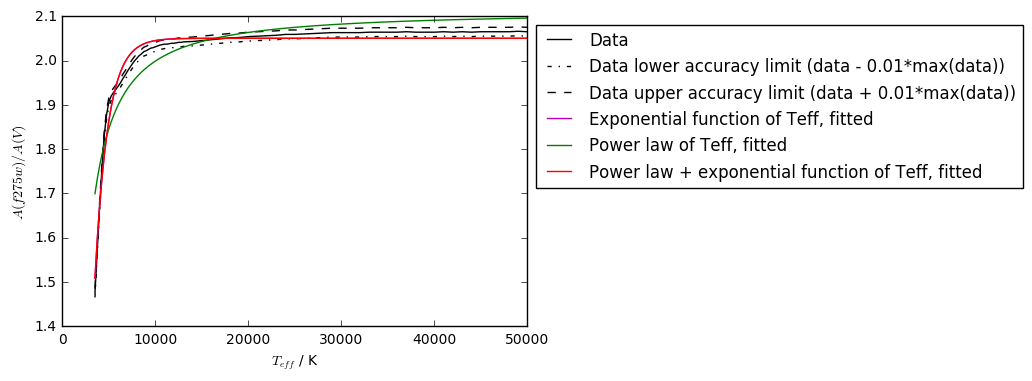


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00335025182227
Average fractional error for Power law of Teff, fitted = 0.366032387392
Average fractional error for Power law + exponential function of Teff, fitted = 0.00203141071237
Writing complete for f275w filter
Exponential fit coefficients: 
[ -1.26410276e+00  -2.57780612e-04   2.03195344e+00]
Covariance matrix: 
[[  9.17646177e-04   1.37310288e-07   1.84273834e-05]
 [  1.37310288e-07   2.40980684e-11   5.13689357e-09]
 [  1.84273834e-05   5.13689357e-09   3.50416443e-06]]
Teff^(n) fit coefficients: 
[ -1.00000000e+04  -1.19551298e+00   2.08264516e+00]
Covariance matrix: 
[[  1.18931677e+07   1.44550223e+02   1.67086431e+01]
 [  1.44550223e+02   1.75958723e-03   2.06788662e-04]
 [  1.67086431e+01   2.06788662e-04   3.18450934e-05]]
Teff^(n) + exponential fit coefficients: 
[ -1.26410261e+00  -2.57780244e-04   2.03195388e+00  -3.41770461e+00]
Covariance matrix: 
[[  9.30

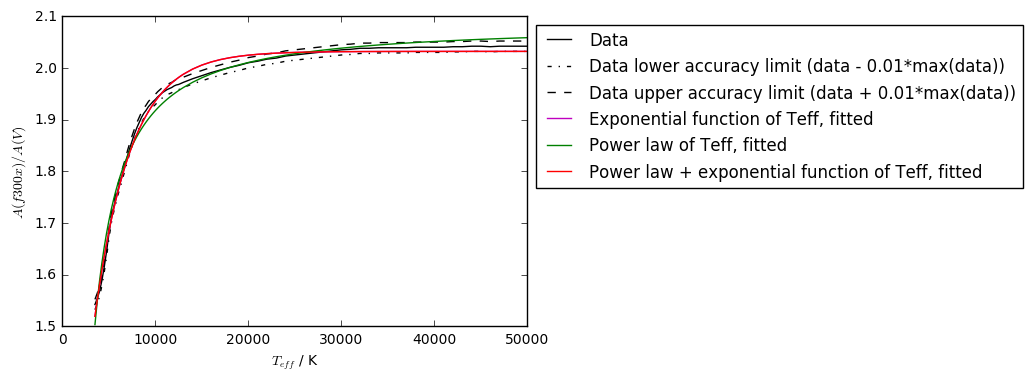


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000229352340211
Average fractional error for Power law of Teff, fitted = 0.0221910899181
Average fractional error for Power law + exponential function of Teff, fitted = 0.000139522111155
Writing complete for f300x filter
Exponential fit coefficients: 
[ -1.32573107e-01  -3.57972854e-04   1.64572174e+00]
Covariance matrix: 
[[  9.44032587e-05   1.50030214e-07   1.01295353e-06]
 [  1.50030214e-07   2.62384932e-10   2.41744830e-09]
 [  1.01295353e-06   2.41744830e-09   7.86902488e-08]]
Teff^(n) fit coefficients: 
[-10.         -0.68063191  1.65652287]
Covariance matrix: 
[[  9.94621998e+01   1.27149302e+00   2.93909584e-02]
 [  1.27149302e+00   1.62872865e-02   3.80731162e-04]
 [  2.93909584e-02   3.80731162e-04   9.59269355e-06]]
Teff^(n) + exponential fit coefficients: 
[ -1.32568860e-01  -3.57965647e-04   1.64572179e+00  -4.98799098e+00]
Covariance matrix: 
[[  9.57054496e-05 

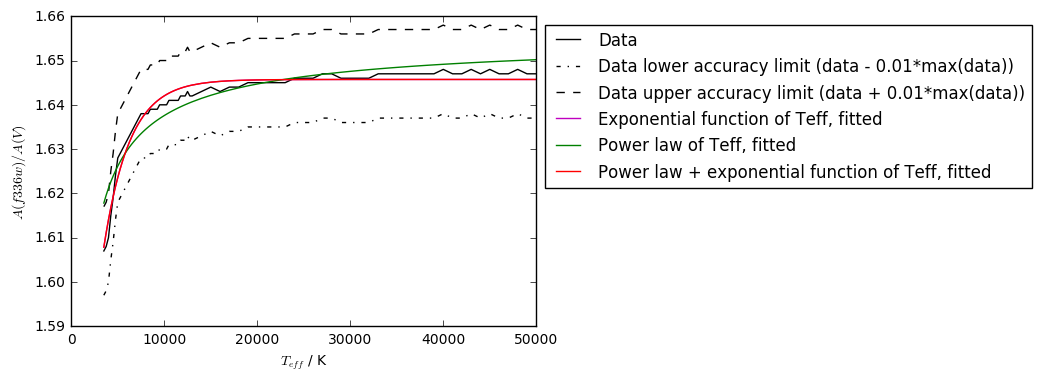


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00176482647613
Average fractional error for Power law of Teff, fitted = 0.203117682964
Average fractional error for Power law + exponential function of Teff, fitted = 0.00107358217056
Writing complete for f336w filter
Exponential fit coefficients: 
[ -7.65099584e-02  -8.00164061e-05   1.48601506e+00]
Covariance matrix: 
[[  5.84961855e-06   9.21863674e-09   4.56750179e-07]
 [  9.21863674e-09   4.05633288e-11   7.37708517e-09]
 [  4.56750179e-07   7.37708517e-09   1.94540459e-06]]
Teff^(n) fit coefficients: 
[-0.90071027 -0.22795331  1.56338266]
Covariance matrix: 
[[ 0.1040865   0.02252395  0.01001023]
 [ 0.02252395  0.004897    0.00218836]
 [ 0.01001023  0.00218836  0.00098439]]
Teff^(n) + exponential fit coefficients: 
[ -7.65101927e-02  -8.00181208e-05   1.48601465e+00  -4.16086352e+00]
Covariance matrix: 
[[  5.93114192e-06   9.34729896e-09   4.63140405e-07   0.00000000e+0

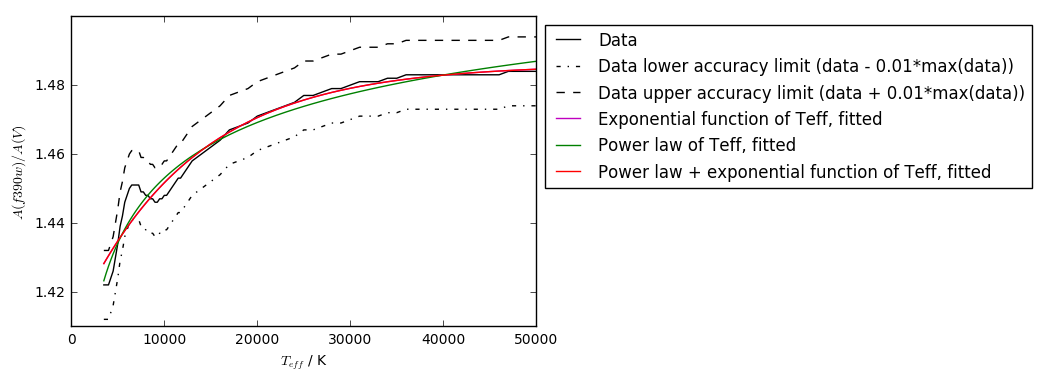


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00148457661843
Average fractional error for Power law of Teff, fitted = 0.0576489662814
Average fractional error for Power law + exponential function of Teff, fitted = 0.000903113726439
Writing complete for f390w filter
Exponential fit coefficients: 
[ -8.40590653e-02  -2.60487792e-04   1.35073756e+00]
Covariance matrix: 
[[  2.51112862e-05   5.67186694e-08   4.96140375e-07]
 [  5.67186694e-08   1.49897499e-10   2.07078081e-09]
 [  4.96140375e-07   2.07078081e-09   9.17942547e-08]]
Teff^(n) fit coefficients: 
[ -2.29160372e+03  -1.34697227e+00   1.35308805e+00]
Covariance matrix: 
[[  2.30354517e+06   1.21652886e+02   7.28135600e-01]
 [  1.21652886e+02   6.43373019e-03   3.91826452e-05]
 [  7.28135600e-01   3.91826452e-05   3.36910501e-07]]
Teff^(n) + exponential fit coefficients: 
[ -8.40590849e-02  -2.60487846e-04   1.35073756e+00  -4.97135806e+00]
Covariance matrix: 
[[  2.

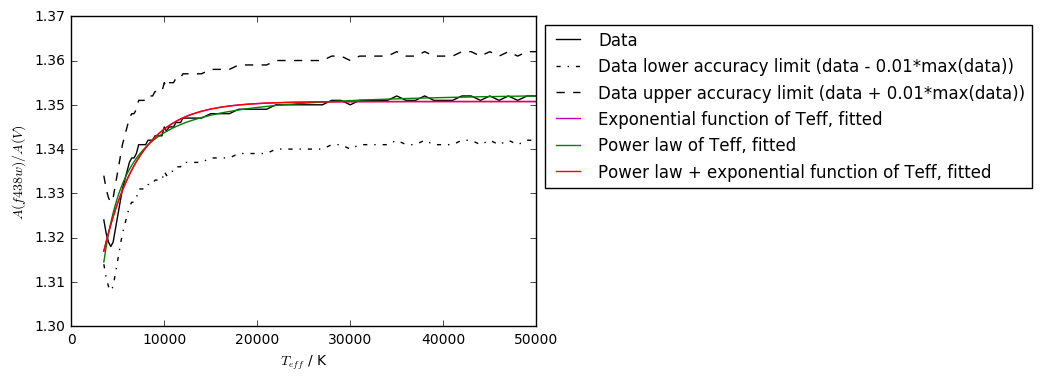


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00139393454803
Average fractional error for Power law of Teff, fitted = 0.0803106231563
Average fractional error for Power law + exponential function of Teff, fitted = 0.00084797699147
Writing complete for f438w filter
Exponential fit coefficients: 
[ -1.85298684e-01  -2.49662526e-04   1.21773030e+00]
Covariance matrix: 
[[  2.83075255e-05   2.85630262e-08   5.96724149e-07]
 [  2.85630262e-08   3.40570207e-11   1.15056007e-09]
 [  5.96724149e-07   1.15056007e-09   1.23348673e-07]]
Teff^(n) fit coefficients: 
[ -3.75283664e+03  -1.30524888e+00   1.22338071e+00]
Covariance matrix: 
[[  2.74181919e+06   8.85038656e+01   1.30366522e+00]
 [  8.85038656e+01   2.86098622e-03   4.28727210e-05]
 [  1.30366522e+00   4.28727210e-05   8.88266845e-07]]
Teff^(n) + exponential fit coefficients: 
[ -1.85297969e-01  -2.49661812e-04   1.21773032e+00  -4.87380471e+00]
Covariance matrix: 
[[  2.8

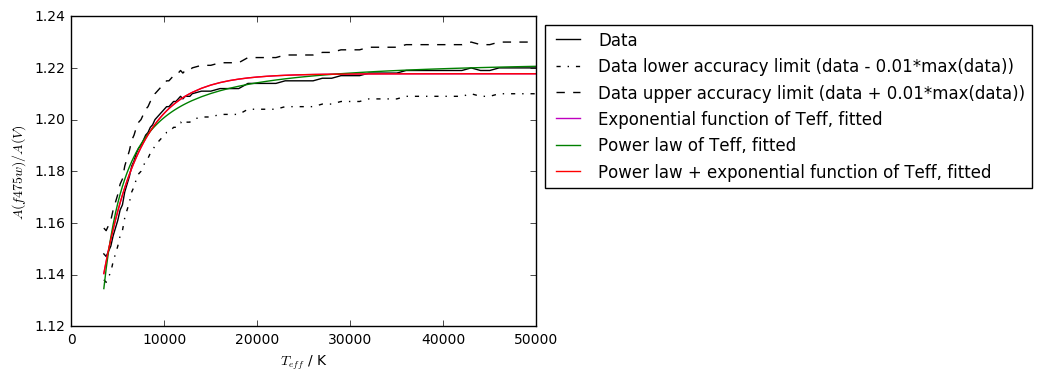


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00033245868614
Average fractional error for Power law of Teff, fitted = 0.0357896393177
Average fractional error for Power law + exponential function of Teff, fitted = 0.000202245558808
Writing complete for f475w filter
Exponential fit coefficients: 
[ -2.28949832e-01  -3.07965664e-04   1.07762940e+00]
Covariance matrix: 
[[  4.29609007e-05   3.77392417e-08   6.34468232e-07]
 [  3.77392417e-08   3.74513265e-11   9.13931025e-10]
 [  6.34468232e-07   9.13931025e-10   7.48569616e-08]]
Teff^(n) fit coefficients: 
[ -9.99999999e+03  -1.42986774e+00   1.08302165e+00]
Covariance matrix: 
[[  1.40870335e+07   1.70224229e+02   1.98934906e+00]
 [  1.70224229e+02   2.05971793e-03   2.44997455e-05]
 [  1.98934906e+00   2.44997455e-05   4.29147905e-07]]
Teff^(n) + exponential fit coefficients: 
[ -2.28950380e-01  -3.07966178e-04   1.07762939e+00  -4.89868221e+00]
Covariance matrix: 
[[  4.

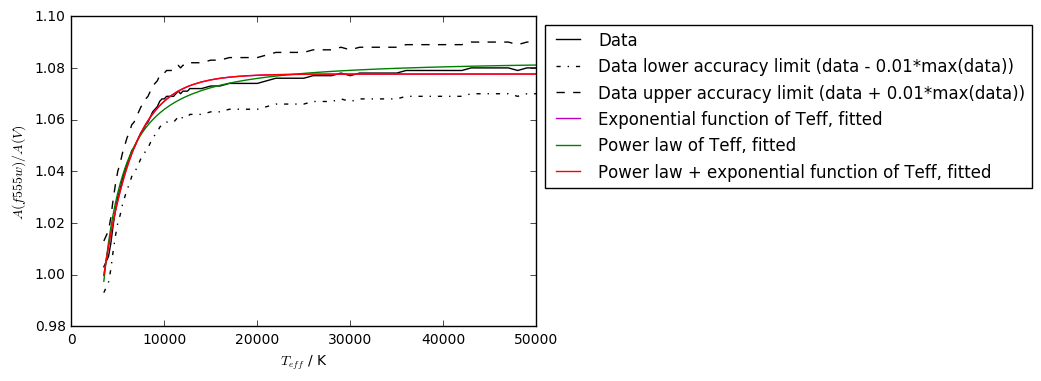


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00029251543775
Average fractional error for Power law of Teff, fitted = 0.0256637555122
Average fractional error for Power law + exponential function of Teff, fitted = 0.000177947129364
Writing complete for f555w filter
Exponential fit coefficients: 
[ -2.27410277e-01  -2.97396474e-04   9.62313842e-01]
Covariance matrix: 
[[  4.06427816e-05   3.55316963e-08   6.41125630e-07]
 [  3.55316963e-08   3.53315278e-11   9.40571226e-10]
 [  6.41125630e-07   9.40571226e-10   8.32054910e-08]]
Teff^(n) fit coefficients: 
[ -1.00000000e+04  -1.42481653e+00   9.67749758e-01]
Covariance matrix: 
[[  1.13779019e+07   1.37498770e+02   1.68729308e+00]
 [  1.37498770e+02   1.66387926e-03   2.07812427e-05]
 [  1.68729308e+00   2.07812427e-05   3.81233579e-07]]
Teff^(n) + exponential fit coefficients: 
[ -2.27410050e-01  -2.97396209e-04   9.62313856e-01  -4.87849390e+00]
Covariance matrix: 
[[  4.

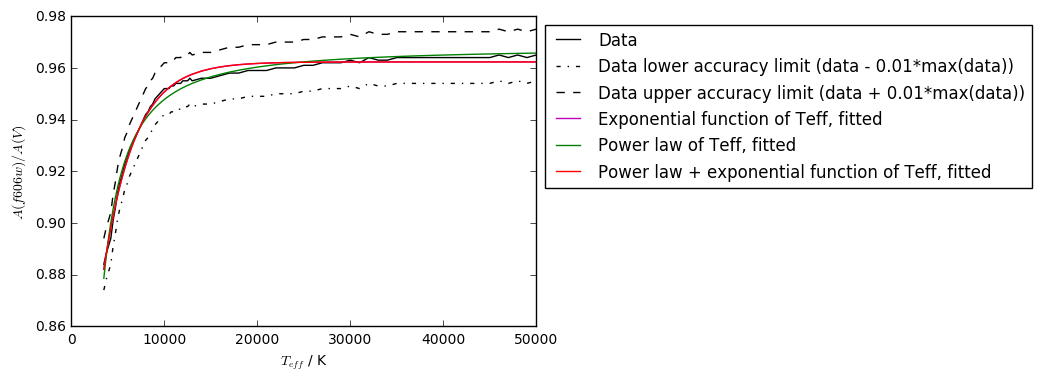


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000286175098648
Average fractional error for Power law of Teff, fitted = 0.0207397886409
Average fractional error for Power law + exponential function of Teff, fitted = 0.000174089659621
Writing complete for f606w filter
Exponential fit coefficients: 
[ -9.34641275e-02  -3.42561115e-04   8.78037340e-01]
Covariance matrix: 
[[  9.67399136e-06   2.15255065e-08   1.14673997e-07]
 [  2.15255065e-08   5.30847987e-11   3.92393655e-10]
 [  1.14673997e-07   3.92393655e-10   1.00780745e-08]]
Teff^(n) fit coefficients: 
[-99.99998883  -1.00189109   0.88237619]
Covariance matrix: 
[[  7.00097914e+03   8.59324521e+00   6.92286009e-02]
 [  8.59324521e+00   1.05657227e-02   8.64049698e-05]
 [  6.92286009e-02   8.64049698e-05   8.49030536e-07]]
Teff^(n) + exponential fit coefficients: 
[ -9.34641418e-02  -3.42561139e-04   8.78037340e-01  -2.47206433e+00]
Covariance matrix: 
[[  3.04847953e-0

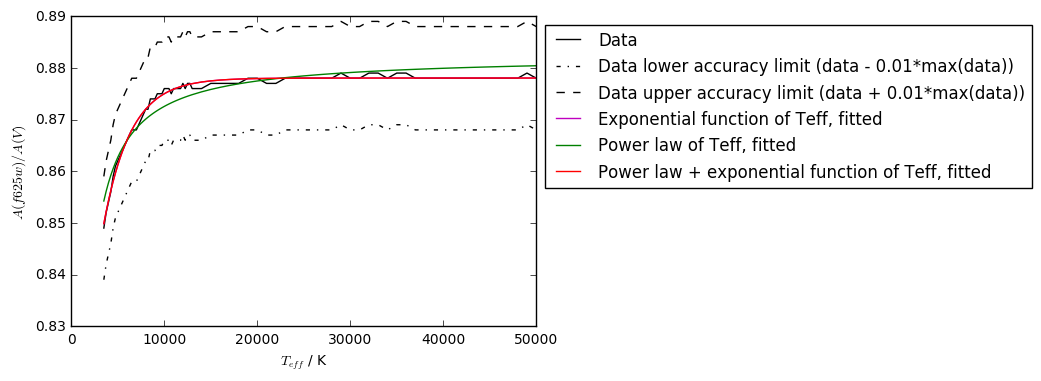


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.000372470869076
Average fractional error for Power law of Teff, fitted = 0.132879600996
Average fractional error for Power law + exponential function of Teff, fitted = 84945181.6781
Writing complete for f625w filter
Exponential fit coefficients: 
[ -7.52274602e-02  -4.05733177e-04   6.55745533e-01]
Covariance matrix: 
[[  5.20708746e-05   1.50944696e-07   4.08748460e-07]
 [  1.50944696e-07   4.72923447e-10   1.67676095e-09]
 [  4.08748460e-07   1.67676095e-09   2.22386183e-08]]
Teff^(n) fit coefficients: 
[-99.99999999  -1.06014746   0.65845424]
Covariance matrix: 
[[  8.68548911e+03   1.06219941e+01   4.74602372e-02]
 [  1.06219941e+01   1.30118593e-02   5.90482882e-05]
 [  4.74602372e-02   5.90482882e-05   3.30039031e-07]]
Teff^(n) + exponential fit coefficients: 
[ -7.52288824e-02  -4.05737177e-04   6.55745523e-01  -3.13900507e+00]
Covariance matrix: 
[[  5.27967122e-05   1

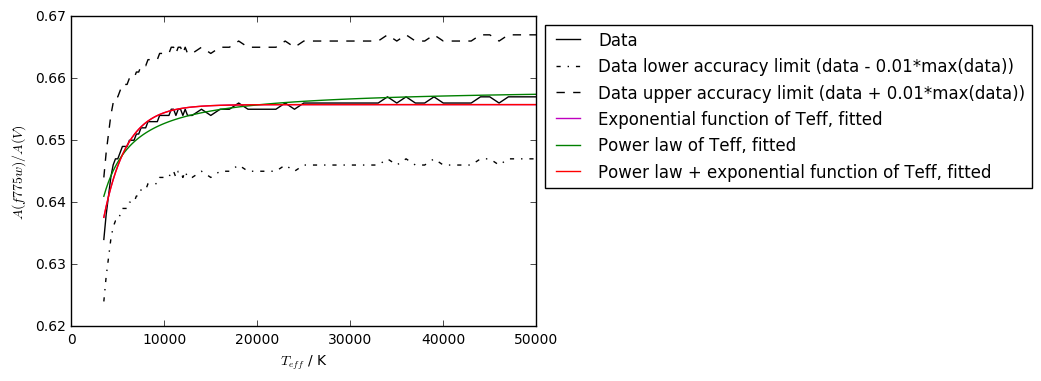


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00283900213192
Average fractional error for Power law of Teff, fitted = 0.163520980742
Average fractional error for Power law + exponential function of Teff, fitted = 0.00172707209608
Writing complete for f775w filter
Exponential fit coefficients: 
[ -9.98876528e-02  -3.29815485e-04   6.13742459e-01]
Covariance matrix: 
[[  5.12246581e-05   1.05419392e-07   6.58877334e-07]
 [  1.05419392e-07   2.42021654e-10   2.13114736e-09]
 [  6.58877334e-07   2.13114736e-09   6.43514524e-08]]
Teff^(n) fit coefficients: 
[-99.9999999   -0.98333319   0.61900386]
Covariance matrix: 
[[  4.95649913e+03   6.09181853e+00   5.92766287e-02]
 [  6.09181853e+00   7.50014291e-03   7.40692981e-05]
 [  5.92766287e-02   7.40692981e-05   8.72272415e-07]]
Teff^(n) + exponential fit coefficients: 
[ -9.98864070e-02  -3.29812337e-04   6.13742508e-01  -4.97157333e+00]
Covariance matrix: 
[[  5.19339303e-05  

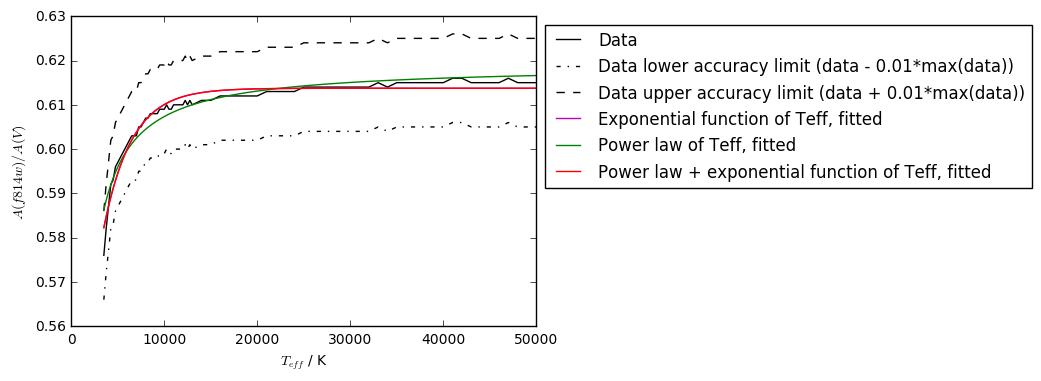


    Writing log(g)=5.0, Z = solar model
Average fractional error for Exponential function of Teff, fitted = 0.00176337655964
Average fractional error for Power law of Teff, fitted = 0.094406456387
Average fractional error for Power law + exponential function of Teff, fitted = 0.00107270794485
Writing complete for f814w filter

 Writing complete for log(g) = 5.0, Z = solar configuration, END OF FUNCTION WRITING!!!


In [6]:
# HUBBLE FILTER PLOTTING
# filter string names
hub_filter_str = ['f218w','f225w','f275w','f300x','f336w','f390w','f438w','f475w','f555w','f606w','f625w','f775w','f814w']
# curve fitting coefficients' bounds
exp_bounds_f218w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f218w = ([-1.0e+07, -2., -5.], [1., 2., 5.])
spp_bounds_f218w = ([-1.0e+02, -10., -4., -6.], [1., 10., 3., 3.])

exp_bounds_f225w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f225w = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f225w = ([-1.0e+04, -10., -4., -5.], [1., 10., 3., 1.])

exp_bounds_f275w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f275w = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f275w = ([-1.0e+05, -10., -4., -5.], [1., 10., 4., 2.])

exp_bounds_f300x = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f300x = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f300x = ([-1.0e+05, -10., -4., -5.], [1., 10., 3., 1.])

exp_bounds_f336w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f336w = ([-1.0e+01, -1., -5.], [1., 1., 5.])
spp_bounds_f336w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds_f390w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f390w = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f390w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds_f438w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f438w = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f438w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds_f475w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f475w = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f475w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds_f555w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f555w = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f555w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds_f606w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f606w = ([-1.0e+04, -2., -5.], [1., 2., 5.])
spp_bounds_f606w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds_f625w = ([-100., -1. ,-5.], [1., 1., 5.])
pow_bounds_f625w = ([-1.0e+02, -2., -5.], [1., 2., 5.])
spp_bounds_f625w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 2.])

exp_bounds_f775w = ([-100., -1. ,-5.], [1., 1., 5.])
pow_bounds_f775w = ([-1.0e+02, -2., -5.], [1., 3., 5.])
spp_bounds_f775w = ([-1.0e+05, -10., -4., -5.], [1., 10., 3., 1.])

exp_bounds_f814w = ([-100., -1. ,-5.], [0., 1., 5.])
pow_bounds_f814w = ([-1.0e+02, -2., -5.], [1., 2., 5.])
spp_bounds_f814w = ([-1.0e+05, -10., -4., -5.], [1., 10., 2., 1.])

exp_bounds = [exp_bounds_f218w,exp_bounds_f225w,exp_bounds_f275w,exp_bounds_f300x,exp_bounds_f336w,exp_bounds_f390w,exp_bounds_f438w,exp_bounds_f475w,exp_bounds_f555w,exp_bounds_f606w,exp_bounds_f625w,exp_bounds_f775w,exp_bounds_f814w]
pow_bounds = [pow_bounds_f218w,pow_bounds_f225w,pow_bounds_f275w,pow_bounds_f300x,pow_bounds_f336w,pow_bounds_f390w,pow_bounds_f438w,pow_bounds_f475w,pow_bounds_f555w,pow_bounds_f606w,pow_bounds_f625w,pow_bounds_f775w,pow_bounds_f814w]
spp_bounds = [spp_bounds_f218w,spp_bounds_f225w,spp_bounds_f275w,spp_bounds_f300x,spp_bounds_f336w,spp_bounds_f390w,spp_bounds_f438w,spp_bounds_f475w,spp_bounds_f555w,spp_bounds_f606w,spp_bounds_f625w,spp_bounds_f775w,spp_bounds_f814w]

print max(A_X_zs_gfix['5.0'][:,5])

filter_curve_plot_write('5.0','solar',exp_bounds,pow_bounds,spp_bounds,hub_filter_str,'HubWFC','Hub_graphs')

In [26]:
"""
exp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))
pow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))
spp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))
#log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))

fig, ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel(var_names[4])

ax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limit (data - 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] + 0.01),'k',linestyle='--',label='Data upper accuracy limit (data + 0.01)')
ax.plot((A_X_zs_gfix['5.0'])[:,0],exp_func((A_X_zs_gfix['5.0'])[:,0],*exp_fit_A_G5zs),'m',label=fit_types[0])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly((A_X_zs_gfix['5.0'])[:,0],*pow_fit_A_G5zs),'g',label=fit_types[1])
ax.plot((A_X_zs_gfix['5.0'])[:,0],single_poly_plus_exp_func((A_X_zs_gfix['5.0'])[:,0],*spp_exp_fit_A_G5zs),'r',label=fit_types[2])

#ax.set_xlim(3000,10000)
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
fig.savefig('gaia_spectra/gaia_graphs/AGrp_logg=5.0_Teff_fit_plot.pdf', bbox_inches='tight')
"""

"\nexp_fit_A_G5zs, covarr_A_G5zs_ef = curve_fit(exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-5.], [0., 1., 5.]))\npow_fit_A_G5zs, covarr_A_G5zs_pow = curve_fit(single_poly,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.0e+08,-5.,-3.], [1., 1., 4.]))\nspp_exp_fit_A_G5zs, covarr_A_G5zs_spp = curve_fit(single_poly_plus_exp_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-100.,-1.,-4.,-5.], [1.,1.,2.,1.]))\n#log_fit_A_G5zs, covarr_A_G5zs_lf = curve_fit(log_func,(A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4], p0=None, sigma=None,bounds=([-1.,5.0e-07,-5.], [10., 10., 5.]))\n\nfig, ax = plt.subplots()\nax.set_xlabel(var_names[0])\nax.set_ylabel(var_names[4])\n\nax.plot((A_X_zs_gfix['5.0'])[:,0],(A_X_zs_gfix['5.0'])[:,4],'k',label='Data')\nax.plot((A_X_zs_gfix['5.0'])[:,0],((A_X_zs_gfix['5.0'])[:,4] - 0.01),'k',linestyle='-.',label='Data lower accuracy limi

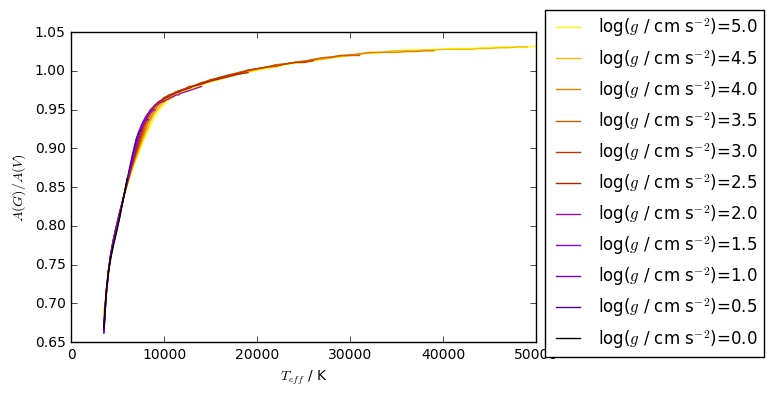

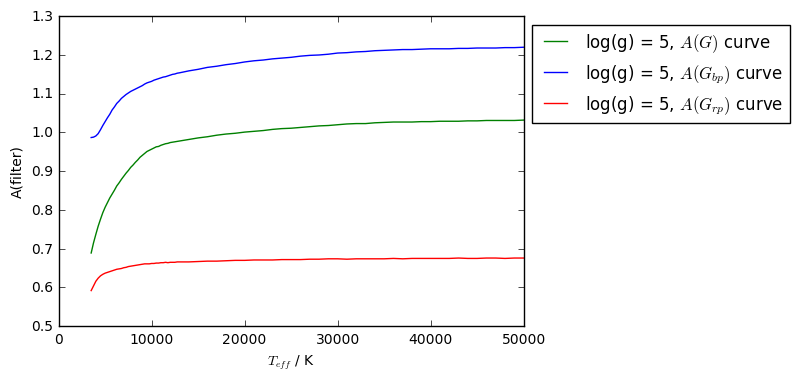

In [7]:
fig, ax = plt.subplots()
col_map = plt.cm.gnuplot
#plt.gca().set_color_cycle([col_map(i) for i in np.linspace(0, 1, len(Teff_vals))])
#gnuplot gist_ncar
#ax.set_xlim(0,15000)
#ax.set_ylim(-2,0)
dict_2D_plot(A_X_zs_gfix,ax,1,3,var_names,col_map)
#fig.savefig('gaia_spectra/gaia_graphs/AG_vs_Teff_at_diff_logg.pdf', bbox_inches='tight')

# plot all 3 filters against Teff together
fig,ax = plt.subplots()
ax.set_xlabel(var_names[0])
ax.set_ylabel('A(filter)')
ax.plot(Teff_5_zs,A_G_5_zs,'g', label = 'log(g) = 5, $A(G)$ curve')
ax.plot(Teff_5_zs,A_Gbp_5_zs,'b', label = 'log(g) = 5, $A(G_{bp})$ curve')
ax.plot(Teff_5_zs,A_Grp_5_zs,'r', label = 'log(g) = 5, $A(G_{rp})$ curve')
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()
#fig.savefig('gaia_spectra/gaia_graphs/Aall_vs_Teff.pdf', bbox_inches='tight')


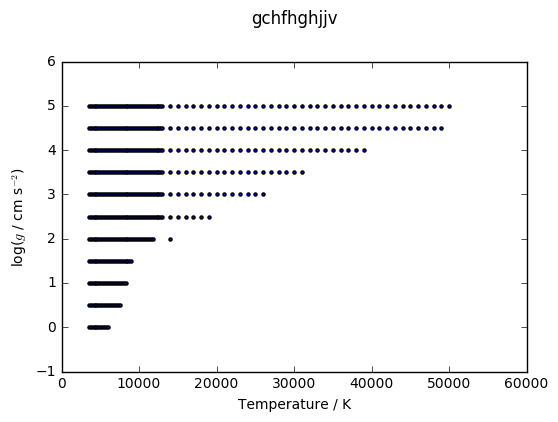

In [44]:
fig, ax = plt.subplots()
#ax.axhline(y=5.0, color='m', linestyle='--')
# Create a continuous norm to map from data points to colors | np.log10((Dthm+1).min()),np.log10((Dthm+1).max())
ax.scatter(T_Av0zs,log_g_Av0zs,marker='.')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('log($g$ / cm s$^{-2}$)')
#ax.set_xlim(['5.02, 0.1])
#ax.set_ylim([0, 0.1])
#plt.show()
#ax.set_title('gchfhghjjv', y=1.1)
fig.savefig('gaia_spectra/gaia_graphs/hgchgftf.pdf', bbox_inches='tight')